In [1]:
import util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from numba import njit
import pickle
import os
import sqlite3
from dotenv import load_dotenv
import yfinance as yf
import strategies
load_dotenv()
util = reload(util)

In [ ]:
kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()

# TIME IS CLOSE TIME
all_data = util.get_all_ochl()

In [3]:
btc_ohlc = all_data[all_data['symbol'] == 'btc'].drop(['symbol', 'coin_id', 'name'], axis=1).set_index('time_rank')
btc_ohlc[['open', 'high', 'low', 'close']] = np.log(btc_ohlc[['open', 'high', 'low', 'close']])
btc_ohlc.sort_index(inplace=True)
total_date_range = pd.date_range(start='2018-02-15 00:00:00+00:00', end=btc_ohlc.index[-1], freq='h', tz=timezone.utc)
btc_ohlc = btc_ohlc.reindex(total_date_range, method='ffill')
btc_ret = btc_ohlc['close'].diff() # if index is t, then ret[t] = close[t] - close[t-1]

In [4]:
in_sample_btc_ohlc = btc_ohlc.loc['2018-02-15':'2023-12-31']
out_of_sample_btc_ohlc = btc_ohlc.loc['2024-01-01':]
len(set(out_of_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))+len(set(in_sample_btc_ohlc.index).difference(set(btc_ohlc.index)))  # should be empty

0

In [ ]:
def permute_series(n, series):
    permuted_returns = {}
    for i in range(n):
        if i == 0:
            permuted_returns[i] = series
            continue
        series = series.sample(frac=1, replace = False).reset_index(drop=True)
        permuted_returns[i] = series
    df = pd.DataFrame(permuted_returns).T
    return df
def indicator_mcpt(n, returns, indicator_func):
    permuted_returns = permute_series(n, returns)
    for i in range(n):
        permuted_returns.iloc[i]
    
    return mcpt

def cmma(prices, window = 24*7):
    
    return short_mavg - long_mavg

(0.0, 50.0)

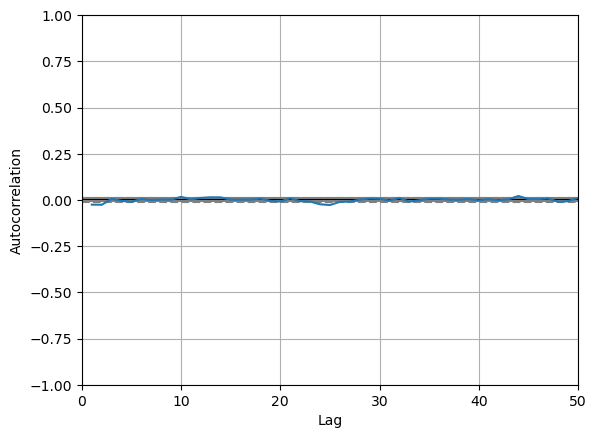

In [18]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(btc_ret.dropna())
ax.set_xlim([0, 50])